In [2]:
import shutil
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
running_on_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') != 'Localhost'

if running_on_kaggle:
    print('Kaggle environment detected')
    data_dir = '/kaggle/input/food41/images/'
else:
    print('Running on localhost')
    data_dir = './dataset/food/images/'
    !pip install --quiet -r requirements.txt
    !python download_data.py

Running on localhost
Traceback (most recent call last):
  File "download_data.py", line 10, in <module>
    from kaggle.api.kaggle_api_extended import KaggleApi
ImportError: No module named kaggle.api.kaggle_api_extended


In [4]:
# Uncomment to select few classes

#classes_to_keep = ['beef_tartare', 'hamburger', 'panna_cotta', 'pizza']
#
#if running_on_kaggle:
#    for elt in classes_to_keep:
#        try:
#            shutil.copytree(data_dir + elt,'/kaggle/temp/images_kept/' + elt)
#        except:
#            print("class ", elt, "already copied !")
#    data_dir = '/kaggle/temp/images_kept/'
#else:
#    for elt in classes_to_keep:
#        shutil.copytree(data_dir + elt,'./dataset/food/images_kept/' + elt, dirs_exist_ok=True)
#    data_dir = './dataset/food/images_kept/'

In [5]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    batch_size=batch_size, 
    shuffle=True,
    seed=70,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    batch_size=batch_size, 
    shuffle=True,
    seed=70,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width))

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Found 101000 files belonging to 101 classes.
Using 20200 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

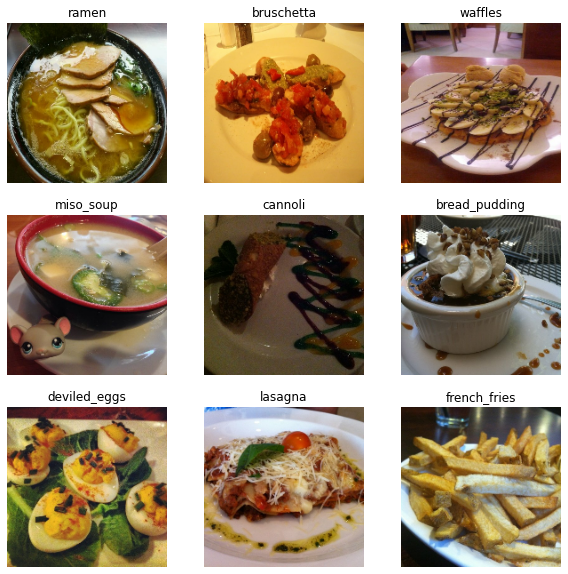

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:
# Put the images in RAM, quicker but only works with few images

#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

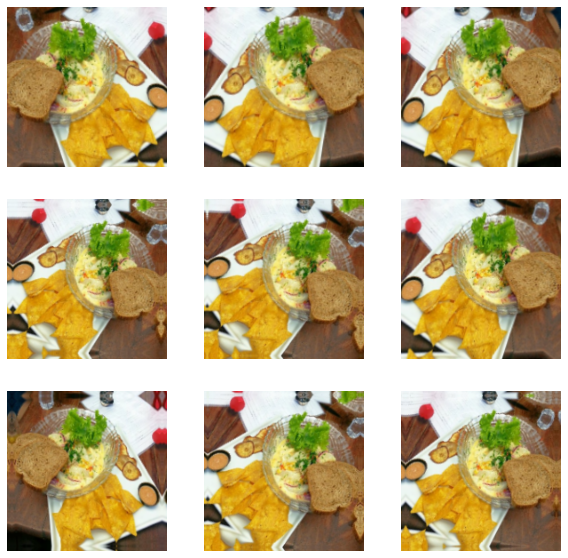

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(15):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Training

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
 103/2525 [>.............................] - ETA: 33:32 - loss: 4.6330 - accuracy: 0.0097

KeyboardInterrupt: 

In [ ]:
if running_on_kaggle:
    model.save('/kaggle/working/saved_model/')
    shutil.make_archive('/kaggle/working/saved_model', 'zip', '/kaggle/working/')
else:
    model.save('./saved_model/')

2022-03-04 10:48:30.552475: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


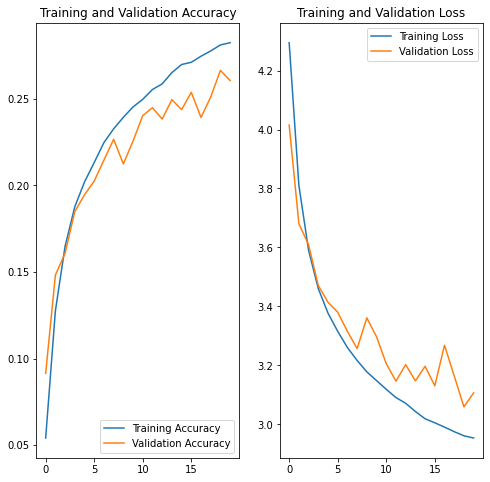

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Unseen data prediction

In [ ]:
pizza_url = "https://img.cuisineaz.com/660x660/2021/02/25/i159373-pizza-margherita.jpeg"
pizza_path = tf.keras.utils.get_file('', origin=pizza_url)

img = tf.keras.utils.load_img(
    pizza_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

212992/202559 [===============================] - 0s 2us/step
This image most likely belongs to pancakes with a 44.13 percent confidence.


## Misclassified images analysis